# Cross Validation and Regularized Regression

## Success Criteria

Today you will be successful if you can...

 * State the purpose of Lasso and Ridge regression
 * Choose the regularization hyperparameter with cross validation
 * Note the differences between Lasso and Ridge regression
 * Perform standardization and normalization, and explain why it is needed with regularization

In [2]:
# Don't normally do this. This is to suppress warnings which happen during 
# demonstration of elasticnet
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from sklearn.metrics import mean_squared_error, make_scorer

from sklearn.linear_model import Lasso, Ridge, ElasticNet


In recent days we've talked about linear regression, in which we find the coefficients $\beta_0$, $\beta_1$, ..., $\beta_p$ to minimize

$$RSS = \sum_{i=1}^n \left( y_i - \left(\beta_0 + \sum_{j=1}^p \beta_j x_{ij} \right) \right)^2$$

In **Ridge Regession** we find the values to minimize

$$ \sum_{i=1}^n \left( y_i - \left(\beta_0 + \sum_{j=1}^p \beta_j x_{ij} \right) \right)^2 + \alpha \sum_{j=1}^{p} \beta_j^2$$

Effectively we've penalizing extreme values of $\beta$ (note that we aren't including $\beta_0$). The value $\alpha$ is a hyperparameter of the model specifying how large the penalty should be.

**Question:** What does this mean if $\alpha = 0$?
<!-- The ridge regression line will be equivalent to the OLS line. (No regularization here) -->

**Question:** What does this mean if $\alpha \to \infty$
<!-- We increase more and more bias. The larger we make alpha, our predictions become less and less senstitive to the features.  -->

**Question:** How should we decide the appropriate value for $\alpha$?
<!-- Cross Validation? yay -->

N.B.: sometimes to coefficient is called $\lambda$.

In **LASSO Regession** (**L**east **A**bsolute **S**hrinkage and **S**election **O**perator) we find the values to minimize

$$ \sum_{i=1}^n \left( y_i - \left(\beta_0 + \sum_{j=1}^p \beta_j x_{ij} \right)\right)^2 + \alpha \sum_{j=1}^{p} | \beta_j |$$

In many ways this is similar to Ridge:
  * We're penalizing large values of $\beta$.
  * We aren't including $\beta_0$.
  * We have a hyperparameter $\alpha$.

The difference is the exponent. Ridge is sometimes known as **L2 regularization**, while LASSO is **L1 regularization**. We'll talk more about this in a bit.


**Question:** how should we decide the appropriate value for $\alpha$?

**Question:** How does this relate to the bias-variance trade-off? If $\alpha$ increases, what happens to the bias? What happens to the variance?

### An Example

Let's use the cars dataset to investigate, predicting the mpg from the other features.

In [3]:
cars = pd.read_csv('cars.csv')

In [4]:
cars.head()

,mpg,cylinders,displacement,horsepower,weight,acceleration,model,origin,car_name
0,18.0,8,307.0,130.0,3504.0,12.0,70,1,chevrolet chevelle malibu
1,15.0,8,350.0,165.0,3693.0,11.5,70,1,buick skylark 320
2,18.0,8,318.0,150.0,3436.0,11.0,70,1,plymouth satellite
3,16.0,8,304.0,150.0,3433.0,12.0,70,1,amc rebel sst
4,17.0,8,302.0,140.0,3449.0,10.5,70,1,ford torino


In [5]:
# Throwing away some bad data. Don't do this at home.
cars = cars[cars.horsepower != '?']
cars.horsepower = cars.horsepower.astype('float64')

In [6]:
cars.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 392 entries, 0 to 397
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   mpg           392 non-null    float64
 1   cylinders     392 non-null    int64  
 2   displacement  392 non-null    float64
 3   horsepower    392 non-null    float64
 4   weight        392 non-null    float64
 5   acceleration  392 non-null    float64
 6   model         392 non-null    int64  
 7   origin        392 non-null    int64  
 8   car_name      392 non-null    object 
dtypes: float64(5), int64(3), object(1)
memory usage: 30.6+ KB


In [7]:
columns = ['cylinders', 'displacement', 'horsepower', 'weight', 'acceleration', 'model']
X = cars[columns].copy()
y = cars['mpg']

We can look at the how the coefficients depend on various values of $\alpha$.

In [11]:
nalphas = 50
min_alpha_exp = -3
max_alpha_exp = 1.5
nfeatures = 6
coefs = np.zeros((nalphas, nfeatures))
alphas = np.logspace(min_alpha_exp, max_alpha_exp, nalphas)
for i, alpha in enumerate(alphas):
    #model = Pipeline([('standardize', StandardScaler()),
    #                  ('lasso', Lasso(alpha=alpha))])
    model = Lasso(alpha=alpha)
    model.fit(X, y)
    #coefs[i] = model.steps[1][1].coef_
    coefs[i] = model.coef_
    


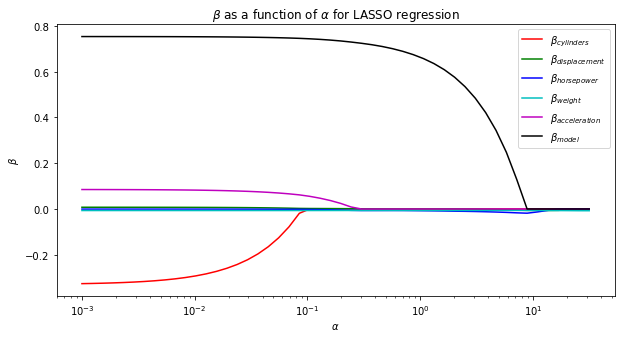

In [12]:
fig, ax = plt.subplots(figsize=(10,5))
for feature, color in zip(range(nfeatures),
                          ['r','g','b','c','m','k']):
    plt.plot(alphas, coefs[:, feature],
             color=color,
             label="$\\beta_{{{}}}$".format(columns[feature]))
ax.set_xscale('log')
ax.set_title("$\\beta$ as a function of $\\alpha$ for LASSO regression")
ax.set_xlabel("$\\alpha$")
ax.set_ylabel("$\\beta$")
ax.legend(loc="upper right")

Discussion: What's going on?

In [17]:
nalphas = 50
min_alpha_exp = 0
max_alpha_exp = 6
coefs = np.zeros((nalphas, nfeatures))
alphas = np.logspace(min_alpha_exp, max_alpha_exp, nalphas)
for i, alpha in enumerate(alphas):
    model = Ridge(alpha=alpha)
    model.fit(X, y)
    coefs[i] = model.coef_

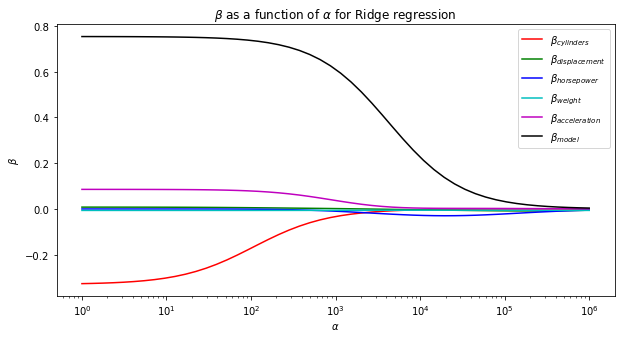

In [18]:
fig, ax = plt.subplots(figsize=(10,5))
for feature, color in zip(range(nfeatures),
                          ['r','g','b','c','m','k']):
    plt.plot(alphas, coefs[:, feature],
             color=color,
             label="$\\beta_{{{}}}$".format(columns[feature]))

ax.set_xscale('log')
ax.set_title("$\\beta$ as a function of $\\alpha$ for Ridge regression")
ax.set_xlabel("$\\alpha$")
ax.set_ylabel("$\\beta$")
ax.legend(loc="upper right")

Discussion: what's going on? How does this differ from LASSO?

In [19]:
def draw_circle(ax, radius, color, x=0, y=0):
    artist = plt.Circle((x, y),
                             radius,
                             color=color,
                             fill=False)
    ax.add_artist(artist)
    return artist
def draw_diamond(ax, radius, color, x=0, y=0):
    artist = plt.Polygon([(x, radius+y),
                               (radius+x, y),
                               (x, -radius+y),
                               (-radius+x, y)],
                              color=color,
                              fill=False)
    ax.add_artist(artist)
    return artist


To help understand this, consider the contour plots of the loss functions for the RMSE, and for the regularization penalty term. Imagine the center of each is the minimum, and we're looking for the minimum of the sum.

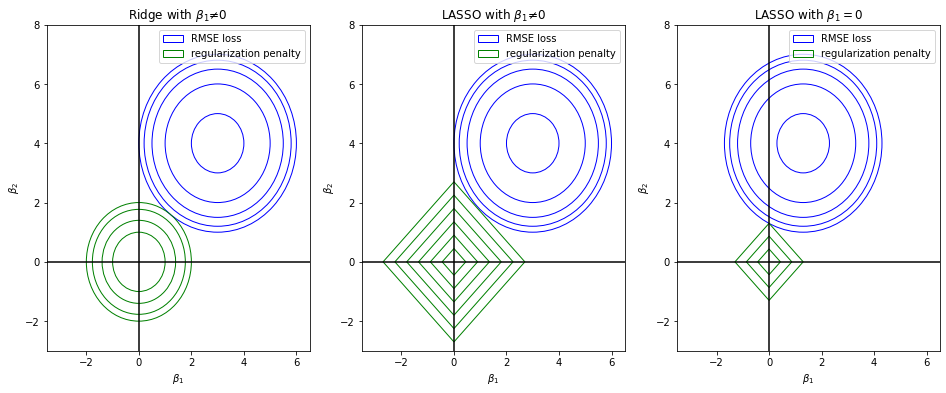

In [20]:
fig, axs = plt.subplots(1, 3, figsize=(16, 6))
for ax in axs:
    ax.axhline(0, color='k')
    ax.axvline(0, color='k')
    ax.set_xlabel(r"$\beta_1$")
    ax.set_ylabel(r"$\beta_2$")

axs[0].set_title(r"Ridge with $\beta_1 \ne 0$")
for r in [1.0, 2.0, 2.5, 2.8, 3.0]:
    artist_loss = draw_circle(axs[0], r, 'b', 3, 4)
for r in [1.0, 1.4, 1.77, 2.0]:
    artist_regularization = draw_circle(axs[0], r, 'g')
axs[0].legend([artist_loss, artist_regularization], ['RMSE loss', 'regularization penalty'])

axs[1].set_title(r"LASSO with $\beta_1 \ne 0$")
for r in [1.0, 2.0, 2.5, 2.8, 3.0]:
    artist_loss = draw_circle(axs[1], r, 'b', 3, 4)
for r in [0.45, 0.9, 1.35, 1.8, 2.25, 2.7]:
    artist_regularization = draw_diamond(axs[1], r, 'g')
axs[1].legend([artist_loss, artist_regularization], ['RMSE loss', 'regularization penalty'])

# Example with LASSO at zero
axs[2].set_title(r"LASSO with $\beta_1 = 0$")
for r in [1.0, 2.0, 2.5, 2.8, 3.0]:
    artist_loss = draw_circle(axs[2], r, 'b', 1.3, 4)
for r in [0.433, 0.866, 1.3]:
    artist_regularization = draw_diamond(axs[2], r, 'g')
axs[2].legend([artist_loss, artist_regularization], ['RMSE loss', 'regularization penalty'])

for ax in axs:
    ax.set_xlim(-3.5, 6.5)
    ax.set_ylim(-3, 8)

The minimum of a sum of functions occurs when the gradient of the sum of the functions is zero. This occurs when the gradients of the two functions are equal and opposite, which occurs when the contour lines are parallel.

In the above plots, imagine the minimum solutions are at the points when the outer contours lines are tangent. For Ridge regression, a minimum at $\beta_i = 0$ is very unlikely, but quite possible for LASSO regression.

### Scaling and regularization

Over the coming weeks we'll talk about a variety of predictive models, and various ways in which they are different. One of those is whether it is necessary to standardize/normalize the features before fitting. First, some definitions:

**Standardization** (in this context) is the process of subtracting the mean from each feature, and then dividing by the standard deviation, so each feature has a mean of 0 and standard deviation of 1.

**Normalization** (again, in this context) is the process of subtracting the minimum value from each feature, and then dividing by the difference of the minimum and maximum, so each feature ranges from 0 to 1.

Both accomplish the same purpose, of having all features on the same scale.

So for some models you need to standardize (or normalize) the features before fitting the model, at least if they have significantly different ranges. It's not that hard to write code to do that, but the transformers in `sklearn` make that a lot easier.

In [22]:
X.head()

,cylinders,displacement,horsepower,weight,acceleration,model
0,8,307.0,130.0,3504.0,12.0,70
1,8,350.0,165.0,3693.0,11.5,70
2,8,318.0,150.0,3436.0,11.0,70
3,8,304.0,150.0,3433.0,12.0,70
4,8,302.0,140.0,3449.0,10.5,70


In [21]:
from sklearn.pipeline import Pipeline
#for standardization
from sklearn.preprocessing import StandardScaler
#for minimization
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import Lasso

model = Pipeline([('standardize', StandardScaler()),
                   ('regressor', Ridge())])

In [23]:
model.fit(X, y)

Pipeline(steps=[('standardize', StandardScaler()), ('regressor', Ridge())])

The pipeline model will take care of the transformations in fitting and prediction automatically. You can normalize using `sklearn.preprocessing.MinMaxScaler`.

In linear regression without regularization, scaling **does not matter**. If you change the scale of a feature (multiplying each value by a constant), it will change the corresponding coefficient **but the predictions will be exactly the same**.

This is not true when we add regularization. Since we include a term that is proportional to the $\beta$, the actual predictions will change it we rescale the values.

As a rule of thumb, if changing the units of the features will change the predictions of a model, you need to standardize (or normalize) the values.


In [24]:
model.named_steps

{'standardize': StandardScaler(), 'regressor': Ridge()}

In [25]:
model.named_steps['regressor'].coef_

array([-0.54916733,  0.66082705, -0.07735632, -5.59706504,  0.19573101,
        2.75371452])

In [26]:
model.named_steps['regressor'].intercept_

23.44591836734694

## Let's do one more example using cross validation to determine our best alpha

In [27]:
X_train, X_holdout, y_train, y_holdout = train_test_split(X.values,y.values, test_size=0.2)

In [28]:
def cross_val(X_train, y_train, model, k = 5):
    ''' Returns error for k-fold cross validation. '''
    kf = KFold(n_splits=k)
    error = np.empty(k)
    index = 0
    for train, test in kf.split(X_train):
        model.fit(X_train[train], y_train[train])
        pred = model.predict(X_train[test])
        error[index] = mean_squared_error(y_train[test], pred, squared = False)
        index += 1
    return np.mean(error)

In [29]:
model = Pipeline([('standardize', StandardScaler()),
                   ('regressor', Ridge())])
cross_val(X_train, y_train, model)

3.567059184566355

In [30]:
cv_scores = []
alphas = np.logspace(-2, 1.5, 20)
for a in alphas:
    cv_score = cross_val(X_train, y_train, Pipeline([('standardize', StandardScaler()),
                   ('regressor', Ridge(alpha = a))]))
    cv_scores.append(cv_score)

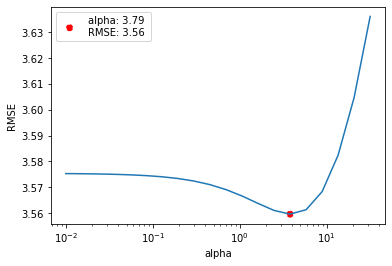

In [31]:
min_score = np.argmin(cv_scores)

fig, ax = plt.subplots()

ax.plot(alphas, cv_scores)
ax.scatter(alphas[min_score], cv_scores[min_score], ls = '--', c = 'r', \
           label = f'alpha: {round(alphas[min_score],2)} \nRMSE: {round(cv_scores[min_score], 2)}')
ax.set_ylabel('RMSE')
ax.set_xlabel('alpha')
ax.set_xscale('log')
plt.legend();

So our training error is 3.47 using RMSE, a perfectly acceptable loss/cost function, leads us to an alpha around 1.62. 


In [32]:
model = Pipeline([('standardize', StandardScaler()),
                   ('regressor', Ridge(alpha = alphas[min_score]))])
model.fit(X_train, y_train)
final_preds = model.predict(X_holdout)
print(f'Train RMSE: {mean_squared_error(model.predict(X_train), y_train, squared=False)}')
print(f'Test RMSE: {mean_squared_error(y_holdout, final_preds, squared=False)}')

Train RMSE: 3.4762079093967926
Test RMSE: 3.14829619978129


### Gridsearch 
Woudln't it be nice to do cross validation to determine the best alphas without having to code all of these for loops? 

Sklearn's GridsearchCV does just that

In [33]:


search_space = [{'regressor__alpha': (np.logspace(-2, 1.5, 20))}]

rmse = make_scorer(mean_squared_error,greater_is_better=False, squared = False)


pipe = Pipeline([('scaler', StandardScaler()), ('regressor', Lasso())])

enet_cv = GridSearchCV(pipe, 
                      search_space, 
                      cv=KFold(10, shuffle=True), 
                      scoring=rmse,
                      return_train_score = True)

enet_cv.fit(X_train,y_train)

enet_cv.best_params_

{'regressor__alpha': 0.0545559478116852}

But we might want to know how our model does using ElasticNet, seeing how it is the best of both worlds and can balance L1 and L2! 

In [34]:
search_space = [{'regressor__alpha': (np.logspace(-2, 2, 30)), \
                'regressor__l1_ratio': (np.linspace(0,1,11))}]

rmse = make_scorer(mean_squared_error,greater_is_better=False, squared = False)


pipe = Pipeline([('scaler', StandardScaler()), ('regressor', ElasticNet())])

enet_cv = GridSearchCV(pipe, 
                      search_space, 
                      cv=KFold(5, shuffle=True), 
                      scoring='neg_mean_squared_error',
                      return_train_score = True)

enet_cv.fit(X_train, y_train)

enet_cv.best_params_

{'regressor__alpha': 0.04893900918477494, 'regressor__l1_ratio': 1.0}